In [1]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from armadata import ARMAVolumeDataset
from statsmodels.stats.outliers_influence import variance_inflation_factor
from arch import arch_model
from scipy.stats import gennorm
import statsmodels.api as sm
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
train_dataset = ARMAVolumeDataset(dt.datetime(2022, 9, 30), dt.datetime(2023, 5, 8))
val_dataset = ARMAVolumeDataset(dt.datetime(2023, 5, 9), dt.datetime(2023, 7, 19))
test_dataset = ARMAVolumeDataset(dt.datetime(2023, 7, 20), dt.datetime(2023, 9, 30))

In [3]:
train_data = train_dataset.process_data()
val_data = val_dataset.process_data()
test_data = test_dataset.process_data()

[INFO] Saved processed dataset to: /Users/Samantha/Downloads/PyTorch-Code-ARMA-ARMA_LSTM-main/processed_arma_volume_dataset.csv
[INFO] Saved processed dataset to: /Users/Samantha/Downloads/PyTorch-Code-ARMA-ARMA_LSTM-main/processed_arma_volume_dataset.csv
[INFO] Saved processed dataset to: /Users/Samantha/Downloads/PyTorch-Code-ARMA-ARMA_LSTM-main/processed_arma_volume_dataset.csv


In [4]:
#MAIN DATA IN SERIES FORM
train_diff = pd.Series(train_data['log_diff_volume'].values)
val_diff   = pd.Series(val_data['log_diff_volume'].values)
test_diff  = pd.Series(test_data['log_diff_volume'].values)

In [5]:
import pandas as pd

# Combine the target and exogenous variables for descriptive stats
train_df = pd.DataFrame({
    'log_diff_volume': train_diff,
    'log_return': train_data['log_return'],
    'relative_open': train_data['relative_open'],
    'relative_high': train_data['relative_high'],
    'relative_low': train_data['relative_low'],
    'relative_close': train_data['relative_close']
})

val_df = pd.DataFrame({
    'log_diff_volume': val_diff,
    'log_return': val_data['log_return'],
    'relative_open': val_data['relative_open'],
    'relative_high': val_data['relative_high'],
    'relative_low': val_data['relative_low'],
    'relative_close': val_data['relative_close']
})

test_df = pd.DataFrame({
    'log_diff_volume': test_diff,
    'log_return': test_data['log_return'],
    'relative_open': test_data['relative_open'],
    'relative_high': test_data['relative_high'],
    'relative_low': test_data['relative_low'],
    'relative_close': test_data['relative_close']
})

# Descriptive statistics
train_stats = train_df.describe().T
val_stats   = val_df.describe().T
test_stats  = test_df.describe().T

print("Train Descriptive Statistics:\n", train_stats)
print("\nValidation Descriptive Statistics:\n", val_stats)
print("\nTest Descriptive Statistics:\n", test_stats)


Train Descriptive Statistics:
                    count      mean       std       min       25%       50%  \
log_diff_volume  11700.0 -0.000002  0.407727 -4.569128 -0.252760 -0.014849   
log_return       11700.0  0.001172  0.135005 -1.885548 -0.052443  0.002484   
relative_open    11700.0  1.000002  0.000624  0.994265  0.999667  0.999988   
relative_high    11700.0  1.000771  0.000496  1.000000  1.000454  1.000641   
relative_low     11700.0  0.999229  0.000496  0.991684  0.999059  0.999359   
relative_close   11700.0  1.000012  0.000586  0.994942  0.999697  1.000024   

                      75%       max  
log_diff_volume  0.239915  9.471484  
log_return       0.055724  3.273376  
relative_open    1.000337  1.006252  
relative_high    1.000941  1.008316  
relative_low     0.999546  1.000000  
relative_close   1.000335  1.005363  

Validation Descriptive Statistics:
                   count      mean       std       min       25%       50%  \
log_diff_volume  3744.0  0.000445  0.53917

In [6]:
#STATIONARY, AUTOCORR TESTS
adf_result = adfuller(train_diff)
print("\n[ADF Test - train_diff]")
print(f"ADF Statistic: {adf_result[0]:.6f}")
print(f"p-value: {adf_result[1]:.6f}")


[ADF Test - train_diff]
ADF Statistic: -25.271467
p-value: 0.000000


In [7]:
lb_test = acorr_ljungbox(train_diff, lags=[20], return_df=True)
p_value = lb_test['lb_pvalue'].iloc[0]
print(f"Ljung-Box p-value at lag 20: {p_value:.6f}")

Ljung-Box p-value at lag 20: 0.000000


#### Added to see a good range for grid searching

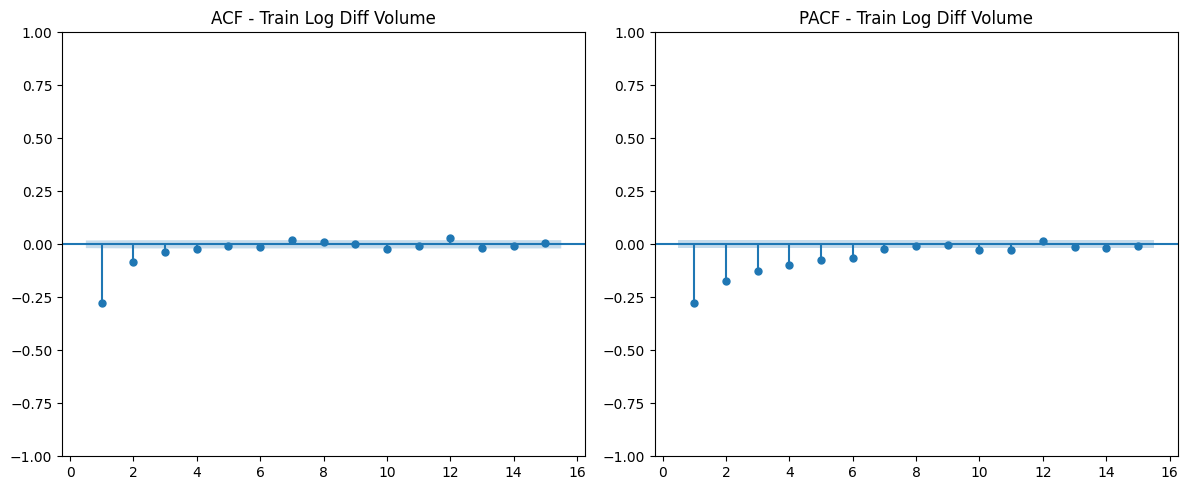

In [8]:
#ACF AND PACF GRAPHS
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(train_diff, lags=15, zero=False, ax=plt.gca())
plt.title("ACF - Train Log Diff Volume")
plt.subplot(1, 2, 2)
plot_pacf(train_diff, lags=15, zero=False, ax=plt.gca())
plt.title("PACF - Train Log Diff Volume")
plt.tight_layout()
plt.show()

#### Previously tried p & q until 10 but worried about overfitting since it started giving ARMA(7,...) as best model

In [9]:
#CHOOSE THE BEST ARIMAX MODEL
orders = {}
for q in range(1, 3):
    orders[f"MA({q})"] = (0, 0, q)

for p in range(1, 3):
    orders[f"AR({p})"] = (p, 0, 0)

for p in range(1, 3):
    for q in range(1, 3):
        orders[f"ARMA({p},{q})"] = (p, 0, q)

for p in range(1, 3):
    for d in range(1, 3):
        for q in range(1, 3):
            orders[f"ARIMA({p},{d},{q})"] = (p, d, q)

In [10]:
orders

{'MA(1)': (0, 0, 1),
 'MA(2)': (0, 0, 2),
 'AR(1)': (1, 0, 0),
 'AR(2)': (2, 0, 0),
 'ARMA(1,1)': (1, 0, 1),
 'ARMA(1,2)': (1, 0, 2),
 'ARMA(2,1)': (2, 0, 1),
 'ARMA(2,2)': (2, 0, 2),
 'ARIMA(1,1,1)': (1, 1, 1),
 'ARIMA(1,1,2)': (1, 1, 2),
 'ARIMA(1,2,1)': (1, 2, 1),
 'ARIMA(1,2,2)': (1, 2, 2),
 'ARIMA(2,1,1)': (2, 1, 1),
 'ARIMA(2,1,2)': (2, 1, 2),
 'ARIMA(2,2,1)': (2, 2, 1),
 'ARIMA(2,2,2)': (2, 2, 2)}

## (1) Find the best ARIMA, fit train_diff then get MSE on val_diff

In [11]:
val_diff.index = pd.RangeIndex(start=train_diff.index[-1] + 1, stop=train_diff.index[-1] + 1 + len(val_diff))
test_diff.index = pd.RangeIndex(start=val_diff.index[-1] + 1, stop=val_diff.index[-1] + 1 + len(test_diff))

In [12]:
print(f"Alignment Correct: {val_diff.index[0] == train_diff.index[-1] + 1}")

Alignment Correct: True


In [13]:
results = []

for name, order in orders.items():
    model = ARIMA(train_diff, order=order)
    model_fit = model.fit()
    
    updated_model = model_fit.append(val_diff)
    forecast_series = updated_model.predict(start=val_diff.index[0], end=val_diff.index[-1], dynamic=False)
    
    forecast_series.index = val_diff.index

    mse = mean_squared_error(val_diff, forecast_series)
    results.append({'model': name, 'order': order, 'MSE': mse})

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as 

In [14]:
results_df = pd.DataFrame(results).sort_values('MSE')
print("\n[MODEL COMPARISON SUMMARY]")
print(results_df.to_string(index=False))


[MODEL COMPARISON SUMMARY]
       model     order          MSE
   ARMA(2,1) (2, 0, 1) 2.405144e-01
   ARMA(1,2) (1, 0, 2) 2.405263e-01
ARIMA(2,1,2) (2, 1, 2) 2.406083e-01
   ARMA(2,2) (2, 0, 2) 2.407040e-01
   ARMA(1,1) (1, 0, 1) 2.407272e-01
ARIMA(1,1,2) (1, 1, 2) 2.407486e-01
       MA(2) (0, 0, 2) 2.416498e-01
       MA(1) (0, 0, 1) 2.439844e-01
       AR(2) (2, 0, 0) 2.507909e-01
ARIMA(2,1,1) (2, 1, 1) 2.508121e-01
       AR(1) (1, 0, 0) 2.576431e-01
ARIMA(1,1,1) (1, 1, 1) 2.576610e-01
ARIMA(1,2,2) (1, 2, 2) 2.589203e-01
ARIMA(2,2,1) (2, 2, 1) 4.054682e-01
ARIMA(1,2,1) (1, 2, 1) 4.857341e-01
ARIMA(2,2,2) (2, 2, 2) 7.789954e+14


In [15]:
print(f"TRAIN ENDS AT:   {train_diff.index[-1]}")
print(f"VAL STARTS AT:   {val_diff.index[0]}")
print(f"VAL ENDS AT:     {val_diff.index[-1]}")
print(f"TOTAL VAL LEN:   {len(val_diff)}")

TRAIN ENDS AT:   11699
VAL STARTS AT:   11700
VAL ENDS AT:     15443
TOTAL VAL LEN:   3744


In [16]:
#TO CHECK USING VIF LATER
sing_exog_vars = ['log_return', 'relative_open', 'relative_high', 'relative_low','relative_close']

In [17]:
#CHECK VIF OF EXOG
vif_data = train_data[sing_exog_vars]
X_vif = sm.add_constant(vif_data)

vif_results = pd.DataFrame()
vif_results["Variable"] = X_vif.columns
vif_results["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("\n[VIF CHECK]")
print(vif_results.to_string(index=False))


[VIF CHECK]
      Variable      VIF
         const 0.000000
    log_return 2.339801
 relative_open 2.048584
 relative_high      inf
  relative_low      inf
relative_close 1.888704


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [18]:
#TO TEST EXOG COMBINATIONS AFTER VIF
exog_vars = [
    'log_return', 'relative_open', 'relative_close',
    ['log_return', 'relative_open'],
    ['log_return', 'relative_close'],
    ['relative_open', 'relative_close'],
    ['log_return', 'relative_open', 'relative_close']
]

## (2) Find the best exog, fit on train_diff + train_exog[exog_set] and getting MSE on val_diff + val_exog[exog_set]

In [19]:
#SAVE FOR LATER
results_exog = []
best_mse_exog = np.inf
best_order = results_df.iloc[0]['order'] 

best_train_residuals = None
best_val_residuals = None
best_var = None
best_val_forecast = None

In [20]:
results_exog = []
best_mse_exog = np.inf
best_order = results_df.iloc[0]['order']

for var in exog_vars:
    cols = var if isinstance(var, list) else [var]
    name = "+".join(cols)

    #TRAIN USING COL RELATED TO THE CURRENT TESTED VAR ONLY
    exog_train = train_data[cols].values
    exog_val = val_data[cols].values

    model = ARIMA(train_diff, order=best_order, exog=exog_train)
    model_fit = model.fit()

    exog_val_df = pd.DataFrame(exog_val, index=val_diff.index)
    updated_model = model_fit.append(val_diff, exog=exog_val_df)
    
    forecast_series = updated_model.predict(start=val_diff.index[0], end=val_diff.index[-1], exog=exog_val_df)

    mse = mean_squared_error(val_diff, forecast_series)
    results_exog.append({'exog_set': name, 'MSE': mse})

    if mse < best_mse_exog:
        best_mse_exog = mse
        best_var = name
        best_val_residuals = val_diff - forecast_series
        best_train_residuals = model_fit.resid
        best_val_forecast = forecast_series

In [21]:
print(f"Check [{best_var}]: {forecast_series.index.equals(val_diff.index)}")

Check [log_return+relative_open+relative_close]: True


In [22]:
exog_results_df = pd.DataFrame(results_exog).sort_values('MSE')

print("\n[EXOGENOUS SELECTION SUMMARY]")
print("\nARIMA order:", best_order)
print(exog_results_df.to_string(index=False))


[EXOGENOUS SELECTION SUMMARY]

ARIMA order: (2, 0, 1)
                               exog_set      MSE
log_return+relative_open+relative_close 0.239891
              log_return+relative_close 0.239897
           relative_open+relative_close 0.240125
                             log_return 0.240228
                          relative_open 0.240251
               log_return+relative_open 0.240306
                         relative_close 0.240518


#### Slight improvement from ARMA(2,1) MSE: 2.405144e-01

In [23]:
#SAVE FOR LATER
best_row = exog_results_df.iloc[0]
best_exog_cols = best_row['exog_set'].split('+')

## (3) Calculate mean residuals train_residuals, val_residuals; get best_test_residuals later

In [24]:
#BEST_*_RESIDUALS CAME FROM THE EXOG FINDER LOOP
best_train_val_residuals = pd.concat([best_train_residuals, best_val_residuals])

In [25]:
#CHECK FOR GARCH EFFECTS
arch_lm_result = het_arch(best_train_residuals)
print("\n[ARCH-LM Test - train_residuals]")
print(f"ARCH-LM Statistic: {arch_lm_result[0]:.6f}")
print(f"p-value: {arch_lm_result[1]:.6f}")


[ARCH-LM Test - train_residuals]
ARCH-LM Statistic: 834.531344
p-value: 0.000000


#### Prevously tried p & q from 1-10 but gave GARCH(10,10) as the best, and thought it might be too much. Checked with literature and found its usually GARCH/EGARCH (1,1)

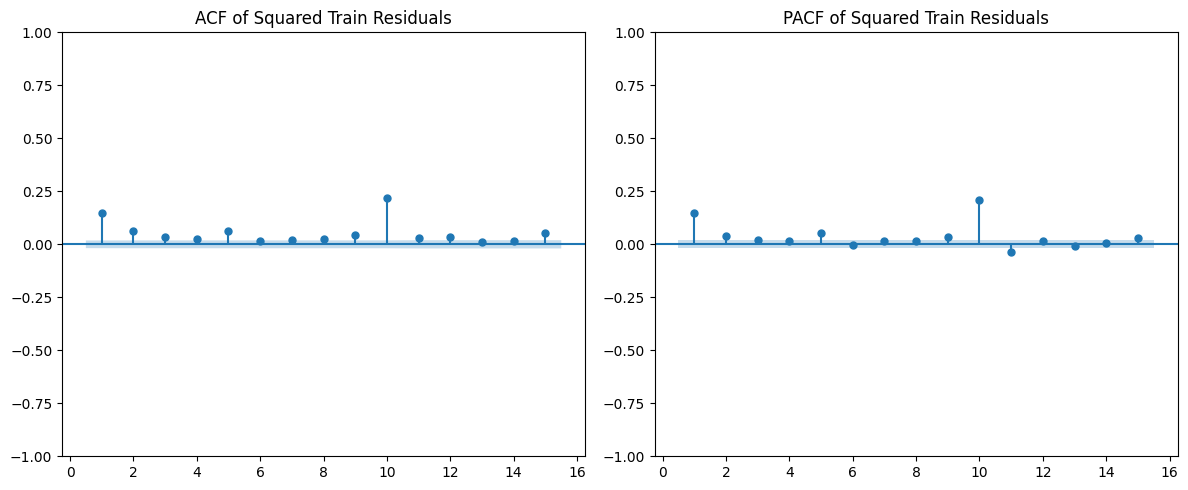

In [26]:
#CHECK CANDIDATE LAGS FOR GARCH
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(np.square(best_train_residuals), lags=15, zero=False, ax=plt.gca())
plt.title("ACF of Squared Train Residuals")
plt.subplot(1, 2, 2)
plot_pacf(np.square(best_train_residuals), lags=15, zero=False, ax=plt.gca())
plt.title("PACF of Squared Train Residuals")
plt.tight_layout()
plt.show()

## (4) Find best GARCH order by fitting on train_residuals and getting the MSE on val_residuals

In [27]:
#FIND THE BEST GARCH MODEL
arch_results = []
best_mse_vol = np.inf
best_params_vol = None

#### Getting base prediction + vol prediction, referenced last year's thesis and kept the replications before averaging epsilon

In [28]:
vol_types, lags_p, lags_q, dists = ['GARCH', 'EGARCH'], [1], [1, 2], ['normal', 't', 'ged']
H_val = len(best_val_residuals)

vol_orders = []
for v in vol_types:
    for p in lags_p:
        for q in lags_q:
            for d in dists:
                vol_orders.append((v, p, q, d))

vol_orders

[('GARCH', 1, 1, 'normal'),
 ('GARCH', 1, 1, 't'),
 ('GARCH', 1, 1, 'ged'),
 ('GARCH', 1, 2, 'normal'),
 ('GARCH', 1, 2, 't'),
 ('GARCH', 1, 2, 'ged'),
 ('EGARCH', 1, 1, 'normal'),
 ('EGARCH', 1, 1, 't'),
 ('EGARCH', 1, 1, 'ged'),
 ('EGARCH', 1, 2, 'normal'),
 ('EGARCH', 1, 2, 't'),
 ('EGARCH', 1, 2, 'ged')]

In [29]:
vol_results = []
n_sims = 1000 
rs = np.random.RandomState(0)

for v, p, q, d in vol_orders:
    all_epsilons = [] 
    model_train = arch_model(best_train_residuals, vol=v, p=p, q=q, dist=d, mean="Zero").fit(disp='off')
    model_fixed = arch_model(best_train_val_residuals, vol=v, p=p, q=q, dist=d, mean="Zero").fix(model_train.params)
    val_volatility = model_fixed.conditional_volatility[best_val_residuals.index]

    #REFERENCED https://github.com/paulomercado/ThesisCodes/blob/main/GARCH.py
    for _ in range(n_sims):
        if d == 'normal':
            epsilon = rs.normal(loc=0, scale=1, size=H_val)
        elif d == 't':
            epsilon = rs.standard_t(df=model_train.params['nu'], size=H_val)
        elif d == 'ged':
            epsilon = gennorm.rvs(beta=model_train.params['nu'], size=H_val, random_state=rs)
        all_epsilons.append(epsilon)
    
    avg_epsilon = pd.Series(np.mean(all_epsilons, axis=0), index=val_volatility.index)
    
    simulated_val_noise = val_volatility * avg_epsilon
    final_val_prediction = best_val_forecast + simulated_val_noise
    
    mse = mean_squared_error(val_diff, final_val_prediction)
    vol_results.append({'Model': f"{v}({p},{q})-{d}", 'Avg_MSE': mse})
        
vol_summary = pd.DataFrame(vol_results).sort_values('Avg_MSE')
print("\n[VOLATILITY SUMMARY]")
print(vol_summary.to_string(index=False))


[VOLATILITY SUMMARY]
             Model  Avg_MSE
 GARCH(1,1)-normal 0.239612
      GARCH(1,1)-t 0.239649
EGARCH(1,2)-normal 0.239795
    GARCH(1,2)-ged 0.239808
      GARCH(1,2)-t 0.239830
   EGARCH(1,1)-ged 0.239855
     EGARCH(1,2)-t 0.239895
   EGARCH(1,2)-ged 0.240109
    GARCH(1,1)-ged 0.240331
EGARCH(1,1)-normal 0.240364
 GARCH(1,2)-normal 0.240467
     EGARCH(1,1)-t 0.240785


In [30]:
is_aligned = val_diff.index.equals(final_val_prediction.index) and not (val_diff - final_val_prediction).isna().any()
print(f"Alignment Valid: {is_aligned}")

Alignment Valid: True


In [31]:
avg_epsilon

11700   -0.034604
11701    0.018966
11702   -0.006169
11703   -0.026704
11704   -0.007329
           ...   
15439    0.035709
15440   -0.026950
15441   -0.003669
15442    0.018798
15443    0.012316
Length: 3744, dtype: float64

In [32]:
#SAVE FOR LATER
best_row = vol_summary.iloc[0]
best_garch_params = {
    'vol': best_row['Model'].split('(')[0],
    'p': int(best_row['Model'].split('(')[1].split(',')[0]),
    'q': int(best_row['Model'].split(',')[1].split(')')[0]),
    'dist': best_row['Model'].split('-')[1],
    'mse': best_row['Avg_MSE']
}

In [33]:
test_diff.index = pd.RangeIndex(start=val_diff.index[-1] + 1, stop=val_diff.index[-1] + 1 + len(test_diff))

In [34]:
exog_train_vals = train_data[best_exog_cols].values
exog_val_vals   = val_data[best_exog_cols].values
exog_test_vals  = test_data[best_exog_cols].values

exog_val_df = pd.DataFrame(exog_val_vals, index=val_diff.index, columns=best_exog_cols)
exog_test_df = pd.DataFrame(exog_test_vals, index=test_diff.index, columns=best_exog_cols)

arimax_fit = ARIMA(train_diff.values, order=best_order, exog=pd.DataFrame(exog_train_vals, columns=best_exog_cols)).fit()
updated_arimax_val = arimax_fit.append(val_diff, exog=exog_val_df)
updated_arimax_test = updated_arimax_val.append(test_diff, exog=exog_test_df)

test_forecast = updated_arimax_test.predict(start=test_diff.index[0], end=test_diff.index[-1], exog=exog_test_df)

mse_test = np.mean((test_diff - test_forecast.values)**2)
print(f"ARMAX Test MSE: {mse_test:.6f}")

ARMAX Test MSE: 0.166007


In [35]:
is_synced = not (test_diff - test_forecast).isna().any()

print(f"Index Match: {test_forecast.index.equals(test_diff.index)}")
print(f"Math Alignment Valid: {is_synced}")

Index Match: True
Math Alignment Valid: True


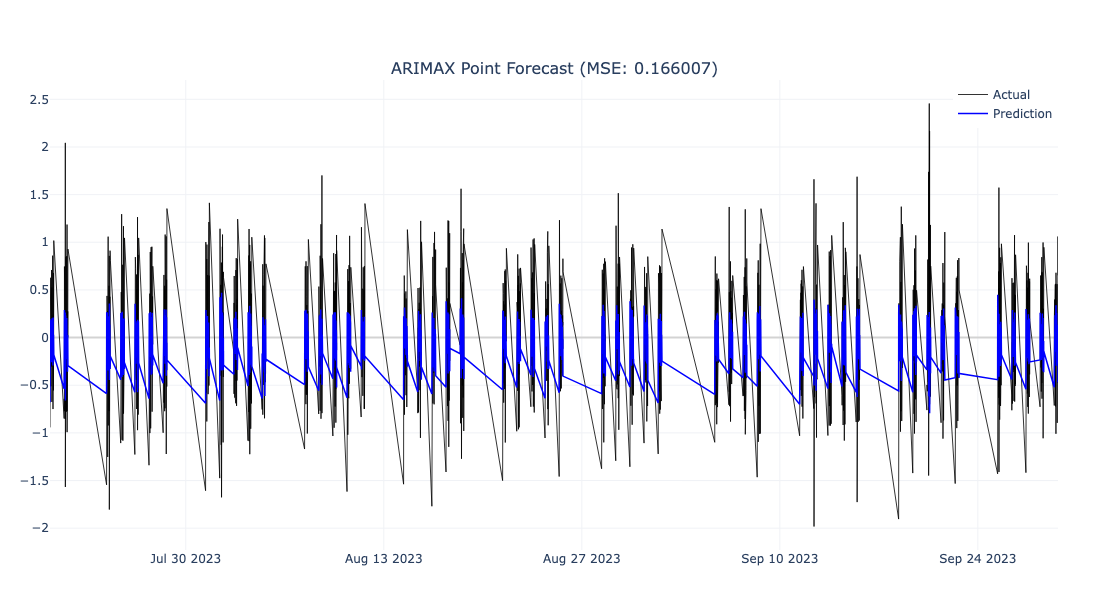

In [36]:
#PLOT RESULTS
fig = make_subplots(rows=1, cols=1, subplot_titles=[f"ARIMAX Point Forecast (MSE: {mse_test:.6f})"])
fig.add_trace(go.Scatter(x=test_data.index[-len(test_diff):], y=test_diff, name="Actual", line=dict(color='black', width=1), opacity=0.8), row=1, col=1)
fig.add_trace(go.Scatter(x=test_data.index[-len(test_diff):], y=test_forecast, name="Prediction", line=dict(color='blue', width=1.5)), row=1, col=1)
fig.update_layout(template="plotly_white", height=600, showlegend=True, legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1), margin=dict(l=50, r=50, t=80, b=50))
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#f0f2f6', tickformat='%b %d %Y')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#f0f2f6', zeroline=True, zerolinecolor='lightgrey')
fig.show()

## (5) Calculate final performance; fit train_diff + train_exog[exog_set], appending val_diff + val_exog[exog_set], and test_diff + test_exog[exog_set] to get test_forecast. Then, fit GARCH on train_resid, append val_resid and test_resid (using .fix) to get conditional volatility and simulated noise

In [37]:
best_test_residuals = test_diff - test_forecast
H_test = len(best_test_residuals)
full_residual_history = pd.concat([best_train_residuals, best_val_residuals, best_test_residuals])

In [38]:
garch_conf = {k: v for k, v in best_garch_params.items() if k != 'mse'}
d = garch_conf['dist']

all_final_epsilons = []
model_train_final = arch_model(best_train_residuals, **garch_conf, mean="Zero").fit(disp="off", show_warning=False)
model_fixed_final = arch_model(full_residual_history, **garch_conf, mean="Zero").fix(model_train_final.params)
test_volatility = model_fixed_final.conditional_volatility[best_test_residuals.index]

for _ in range(n_sims):
    if d == 'normal':
        epsilon = rs.normal(loc=0, scale=1, size=H_test)
    elif d == 't':
        epsilon = rs.standard_t(df=model_train_final.params['nu'], size=H_test)
    elif d == 'ged':
        epsilon = gennorm.rvs(beta=model_train_final.params['nu'], size=H_test, random_state=rs)
    all_final_epsilons.append(epsilon)

avg_final_epsilon = pd.Series(np.mean(all_final_epsilons, axis=0), index=test_volatility.index)

simulated_test_noise = test_volatility * avg_final_epsilon
final_test_prediction = test_forecast + simulated_test_noise

mse_final = mean_squared_error(test_diff, final_test_prediction)
mae_final = mean_absolute_error(test_diff, final_test_prediction)

print(f"Test ARMAX{best_order} MSE: {mse_test:.6f}")
print(f"Test ARMAX{best_order} + {best_garch_params['vol']}({best_garch_params['p']},{best_garch_params['q']}) [{d}] MSE: {mse_final:.6f}")
print(f"Test ARMAX{best_order} + {best_garch_params['vol']}({best_garch_params['p']},{best_garch_params['q']}) [{d}] MAE: {mae_final:.6f}")

Test ARMAX(2, 0, 1) MSE: 0.166007
Test ARMAX(2, 0, 1) + GARCH(1,1) [normal] MSE: 0.165977
Test ARMAX(2, 0, 1) + GARCH(1,1) [normal] MAE: 0.310963
